# In this notebook I write the routine for flight-path calibration

        What it should be done:
        - read the theoretical spectrum
        - read the calibration sample
        - be able to convert from TOF to lambda and back
        - the peak positions are detected and single edge fitting is applied
        - calculate L, T0 or deltaL, which are the results of the calibration 
        
        time to lambda convertion:
            lambda = h/mL (t-t0)
            where:lambda = wavelength [A] (A=0.1nm = 1e-10m)
                    h = Planck's constant: 6.62607004 × 10-34 m^2 kg / s
                    m = Neutron mass [kg]: 1.674 927 471 x 10-27 kg 
                    L = total flight path [m]
                    t = time of flight [s]
        
       Convertion between time of flight and neutron wavelenght can be done after flight-path calibration: the value of the distance between the source and the transmission detector L0  and the time delay of the source trigger DT0, is obtained by linear regression to the function  lambda = h/mL (t-t0), or t= lambda(mL/h)+t0, with h= Planck constant
                    
        

In [ ]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from astropy.io import fits
import os, fnmatch
from os import listdir
%matplotlib inline
import scipy.signal
print(scipy.__version__)
from scipy.signal import find_peaks
from scipy.signal import savgol_filter
import AdvancedBraggEdgeFitting


In [11]:
# Constant values
h=6.62607004e-34 #Planck constant [m^2 kg / s]
m=1.674927471e-27 #Neutron mass [kg]
#theoretical numbers
t0=0
L= 56.4 #[m]
dL = 0

In [3]:
def tof2l(tof):
    l=h/m*(tof-t0)/(L+dL)/1e-10
    return l

def l2tof(l):
    tof=t0+(l*1e-10)*(L+dL)*m/h
    return tof

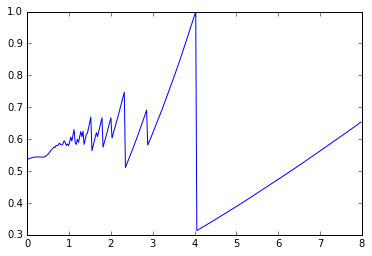

In [22]:
mylambda = np.genfromtxt('lambda.txt',usecols=0)
myspectrum = np.genfromtxt('alpha.txt',usecols=0)

# print(mylambda)
mytof = l2tof(mylambda)
relambda = tof2l(mytof)
plt.plot(mylambda, myspectrum/max(myspectrum))
plt.show()


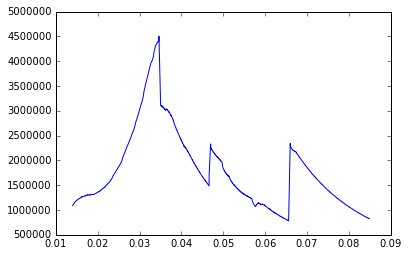

In [6]:
# Read the calibration spectrum from file
mycaltof = np.genfromtxt('/data/data2/IMAT_Nov2018/02_HighStats_radio_1hruns/samples_after_reboot_OC_Fiji/IMAT00010420_HighStats_Radio_1hruns_000_Spectra.txt', usecols=0)
myhist = np.genfromtxt('/data/data2/IMAT_Nov2018/02_HighStats_radio_1hruns/samples_after_reboot_OC_Fiji/IMAT00010420_HighStats_Radio_1hruns_000_Spectra.txt', usecols=1) #this is the cumulative histogram of the raw data (before the overlap correction)



plt.plot(mycaltof,myhist)
plt.show()

In [7]:
# Read the calibration datasets:
# pathdata ="/data/data2/IMAT_Nov2018/02_HighStats_radio_1hruns/samples_after_reboot_OC_Fiji/"
# pathOB = "/data/data2/IMAT_Nov2018/02_HighStats_radio_1hruns/flat_after_reboot_OC_Fiji/"

pathdata ="/data/data2/IMAT_Nov2018/02_HighStats_radio_1hruns/Samples_AfterReboot_Corrected/"
pathOB = "/data/data2/IMAT_Nov2018/02_HighStats_radio_1hruns/Flat_AfterReboot_Corrected/"

In [8]:
myfiles = fnmatch.filter(listdir(pathdata),'*.fits')
coll_files = sorted(myfiles)
print(coll_files[504])
print(coll_files[505])
print(coll_files[506])

obfiles = fnmatch.filter(listdir(pathOB),'*.fits') # here there are several OB folders
coll_ob = sorted(obfiles)
print(coll_ob[504])
print(coll_ob[505])
print(coll_ob[506])
# print(sorted(obfiles))

IMAT00010420_HighStats_Radio_1hruns_000_000504.fits
IMAT00010420_HighStats_Radio_1hruns_000_100000.fits
IMAT00010420_HighStats_Radio_1hruns_000_100001.fits
IMAT00010421_HighStats_Radio_1hruns_000_000504.fits
IMAT00010421_HighStats_Radio_1hruns_000_100000.fits
IMAT00010421_HighStats_Radio_1hruns_000_100001.fits


In [ ]:
# here I don't have repeated measurement for the OB for the cal sample

# # normalized_sample = np.zeros([512,512,len(coll_files)])
# obsubfiles = [None]*len(obfiles)

# for i in range(0, len(obfiles)):
# #     print(obfiles[i])
#     obsubfiles[i]= sorted(fnmatch.filter(listdir(pathOB+obfiles[i]+'/Corrected'),'*.fits')) 

# print(obsubfiles[2][0])

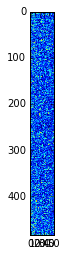

In [9]:
roi_cal = np.array([6,16,57,500])
filename = pathdata + coll_files[0]
im = fits.open(filename)
# plt.imshow(im[0].data)
plt.imshow(im[0].data[roi_cal[1]:roi_cal[3],roi_cal[0]:roi_cal[2]]) #this is the area that I want to study

In [10]:
cal_spectrum = np.zeros(len(coll_files))
cal_ob = np.zeros(len(coll_files))
ori_hist = np.zeros(len(coll_files))

for i in range(0, len(coll_files)):
    
    curr_img = (fits.open(pathdata+coll_files[i])[0].data[roi_cal[1]:roi_cal[3],roi_cal[0]:roi_cal[2]]).astype(float)
    curr_ob =(fits.open(pathOB+coll_ob[i])[0].data[roi_cal[1]:roi_cal[3],roi_cal[0]:roi_cal[2]]).astype(float)
    cal_spectrum[i] = np.sum(curr_img[~np.isnan(curr_img) & ~np.isinf(curr_img)])
    cal_ob[i]= np.sum(curr_ob[~np.isnan(curr_ob) & ~np.isinf(curr_ob)])
    
    

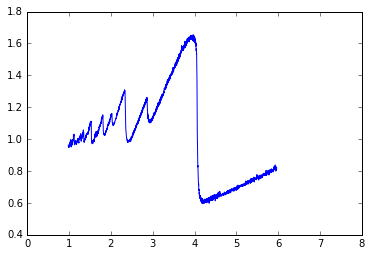

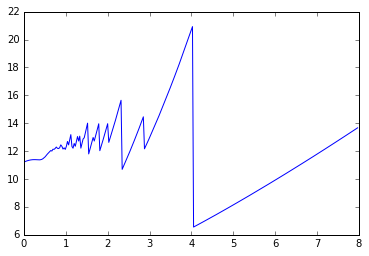

In [12]:
cal_spectrum_norm = -1*np.log(cal_spectrum/cal_ob)
mycalLambda = tof2l(mycaltof)
plt.plot(mycalLambda, -1*np.log(cal_spectrum/cal_ob))
plt.xlim(0,8)
plt.show()

myspectrum_norm = myspectrum/np.average(myspectrum)
plt.plot(mylambda, myspectrum)
plt.xlim(0,8)
plt.show()

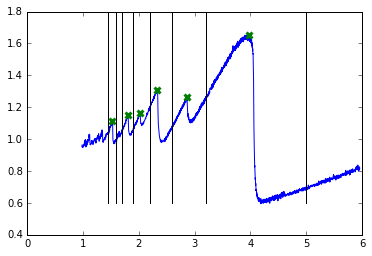

[ 1.52787084  1.80655379  2.02203139  2.32657587  2.86160842  3.96781794]
163


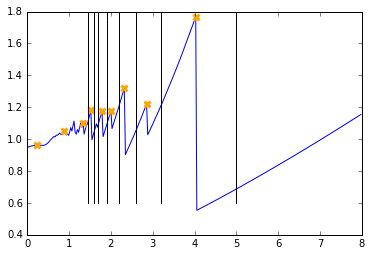

[ 0.24   0.88   1.333  1.52   1.787  2.     2.32   2.853  4.027]


In [13]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return (idx)

lambda_ranges=np.zeros((6,2))


lambda_ranges[5,0] = 3.2
lambda_ranges[5,1] = 5.0

lambda_ranges[4,0] = 2.6
lambda_ranges[4,1] = 3.2

lambda_ranges[3,0] = 2.2
lambda_ranges[3,1] = 2.6

lambda_ranges[2,0] = 1.9
lambda_ranges[2,1] = 2.2

lambda_ranges[1,0] = 1.7
lambda_ranges[1,1] = 1.9

lambda_ranges[0,0] = 1.45
lambda_ranges[0,1] = 1.6

# yhat = savgol_filter(y, 51, 3) # window size 51, polynomial order 3
peaks, _ = find_peaks(cal_spectrum_norm, width=15)
plt.plot(mycalLambda, cal_spectrum_norm)
plt.plot(mycalLambda[peaks],cal_spectrum_norm[peaks],'x', markeredgewidth=3)
for i in range(0,6):
    plt.plot((lambda_ranges[i,0], lambda_ranges[i,0]),(0.6,1.8), 'k-')
    plt.plot((lambda_ranges[i,1], lambda_ranges[i,1]),(0.6,1.8), 'k-')
# plt.ylim(0.8,1.02)
plt.show()
print(mycalLambda[peaks])

print(find_nearest(mycalLambda, lambda_ranges[0,0]))
      

resamp_spectrum = scipy.signal.resample(myspectrum_norm, len(myspectrum_norm)*5)
# plt.plot(resamp_spectrum)
peaks_th, _ = find_peaks(myspectrum_norm, width=2)
plt.plot(mylambda, myspectrum_norm)
plt.plot(mylambda[peaks_th],myspectrum_norm[peaks_th],'x', markeredgewidth=3, c='orange')
for i in range(0,6):
    plt.plot((lambda_ranges[i,0], lambda_ranges[i,0]),(0.6,1.8), 'k-')
    plt.plot((lambda_ranges[i,1], lambda_ranges[i,1]),(0.6,1.8), 'k-')
# plt.ylim(0.3,1.02)
plt.show()
print(mylambda[peaks_th])

---- Peak positions given by the lattice parameters ----
[ 4.054  2.866  2.34   2.026  1.812  1.654  1.532  1.434  1.352  1.352
  1.282  1.222  1.17   1.124  1.124  1.046  1.014  0.984  0.984  0.956
  0.956  0.93   0.93   0.906  0.884  0.864  0.846  0.828  0.81   0.81   0.81
  0.794  0.78   0.78   0.78   0.766  0.752  0.728  0.728  0.716  0.706
  0.706  0.706  0.696  0.696  0.686  0.676  0.676  0.666  0.666  0.666
  0.658  0.65   0.64   0.632  0.626  0.618  0.618  0.612  0.604  0.604
  0.592  0.586  0.58   0.58   0.574  0.568  0.562  0.552  0.546  0.536
  0.536  0.536  0.532  0.518  0.506  0.498  0.496  0.492  0.488  0.478
  0.45   0.448  0.414]


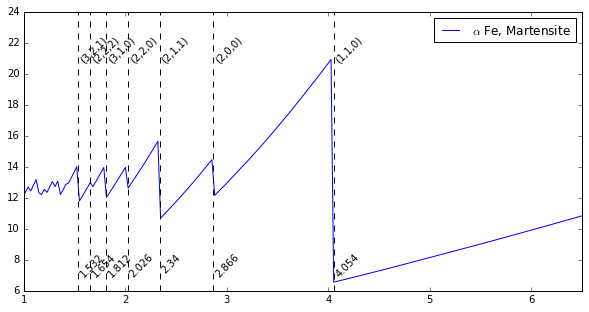

In [14]:
mylambda = np.genfromtxt('lambda.txt',usecols=0)
myalpha = np.genfromtxt('alpha.txt',usecols=0)

dhkl_alphaFe = np.genfromtxt('alphaFe_hkl', usecols=4)
h_alphaFe= np.genfromtxt('alphaFe_hkl', usecols=0)
k_alphaFe= np.genfromtxt('alphaFe_hkl', usecols=1)
l_alphaFe= np.genfromtxt('alphaFe_hkl', usecols=2)


fig, ax = plt.subplots(figsize=(10,5))
plt.plot(mylambda, myalpha, label=r'$\alpha$ Fe, Martensite')

for i in range(0,7):
    plt.plot(np.array([2*dhkl_alphaFe[i],2*dhkl_alphaFe[i]]), np.array([6,24]), '--k')
    mytext = '('+str((h_alphaFe[i]).astype(int))+','+str(k_alphaFe[i].astype(int))+','+str(l_alphaFe[i].astype(int))+')'
    plt.text(2*dhkl_alphaFe[i],22, mytext, rotation=45, color='k')
    plt.text(2*dhkl_alphaFe[i],8, str(2*dhkl_alphaFe[i]), rotation=45, color='k')

plt.legend(loc='upper right')
plt.xlim(1,6.5)

print('---- Peak positions given by the lattice parameters ----')
print(dhkl_alphaFe*2)

[ 190  287  362  468  789 1543]
[  9  33  50  57  67  75  87 107 151]
[ 57  67  75  87 107 151]
--- RefPoints obtained from lattice parameters ---
[ 1.532  1.812  2.026  2.34   2.866  4.054]
[163 215]
[54 60]
-----------Fitting calibration Bragg Edge--------------
[[Model]]
    Model(AdvancedBraggEdegFittingAll)
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 99
    # data points      = 52
    # variables        = 7
    chi-square         = 0.00238
    reduced chi-square = 0.00005
    Akaike info crit   = -505.65049
    Bayesian info crit = -491.99179
[[Variables]]
    t0:      28.6728265 (init= 32.38533)
    sigma:  -0.88427724 (init=-0.03565006)
    alpha:  -0.26394294 (init=-11.55164)
    a1:      0.93378767 (init= 0.941147)
    a2:      0.00189113 (init= 0.004333312)
    a5:     -0.00047878 (init=-0.002614806)
    a6:     -32.7793530 (init=-10.06215)



AdvancedBraggEdgeFitting.py:255: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  plt.plot(t[t0_f], result7.best_fit[t0_f],'ok')


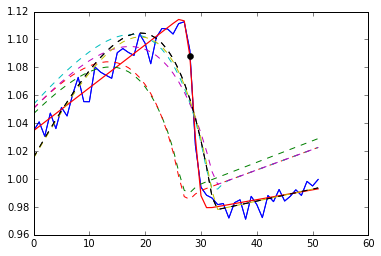

/home/carminati_c/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:43: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/carminati_c/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:44: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
AdvancedBraggEdgeFitting.py:20: RuntimeWarning: overflow encountered in exp
  return np.exp(-((t-t0)/alpha) + ((sigma*sigma)/(2*alpha*alpha)))


-----------Results of fitting, Edge Position, TOF and lambda:------------
(0.0218234, 1.5307466776520611)
[ 0.0218234  0.         0.         0.         0.         0.       ]
[250 320]
[64 71]
-----------Fitting calibration Bragg Edge--------------
[[Model]]
    Model(AdvancedBraggEdegFittingAll)
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 30
    # data points      = 70
    # variables        = 7
    chi-square         = 0.00304
    reduced chi-square = 0.00005
    Akaike info crit   = -689.11740
    Bayesian info crit = -673.37793
[[Variables]]
    t0:      39.8513824 (init= 44.35605)
    sigma:  -1.78557841 (init=-0.5154208)
    alpha:  -0.37222398 (init=-11.82993)
    a1:      0.94130503 (init= 0.9862356)
    a2:      0.00188574 (init= 0.002871999)
    a5:      0.00016105 (init=-0.00126714)
    a6:     -38.5870173 (init=-9.473433)



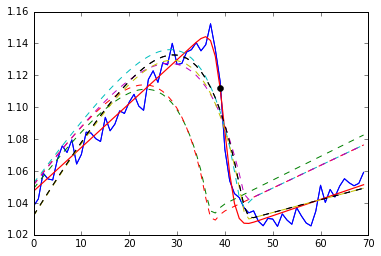

-----------Results of fitting, Edge Position, TOF and lambda:------------
(0.0258374, 1.812298459871851)
[ 0.0218234  0.0258374  0.         0.         0.         0.       ]
[320 424]
[71 83]
-----------Fitting calibration Bragg Edge--------------
[[Model]]
    Model(AdvancedBraggEdegFittingAll)
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 82
    # data points      = 104
    # variables        = 7
    chi-square         = 0.00371
    reduced chi-square = 0.00004
    Akaike info crit   = -1051.12744
    Bayesian info crit = -1032.61670
[[Variables]]
    t0:      45.6579013 (init= 50.0981)
    sigma:  -3.25515727 (init=-1.606121)
    alpha:  -0.24216661 (init=-8.624293)
    a1:     -0.40187386 (init= 0.8001625)
    a2:      0.00228307 (init= 0.002654058)
    a5:      0.00212819 (init= 0.001616734)
    a6:     -620.157188 (init=-80.42003)



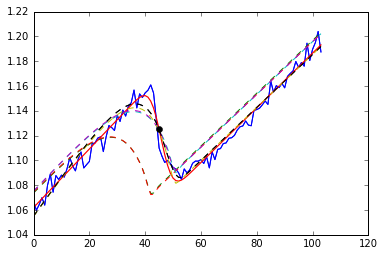

-----------Results of fitting, Edge Position, TOF and lambda:------------
(0.028950400000000001, 2.0306518973532182)
[ 0.0218234  0.0258374  0.0289504  0.         0.         0.       ]
[424 607]
[83 97]
-----------Fitting calibration Bragg Edge--------------
[[Model]]
    Model(AdvancedBraggEdegFittingAll)
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 47
    # data points      = 183
    # variables        = 7
    chi-square         = 0.01902
    reduced chi-square = 0.00011
    Akaike info crit   = -1664.43337
    Bayesian info crit = -1641.96697
[[Variables]]
    t0:      51.4431848 (init= 57.96783)
    sigma:  -4.23786861 (init=-2.525777)
    alpha:  -0.64727783 (init=-12.23581)
    a1:      0.82213609 (init= 0.8656822)
    a2:      0.00166881 (init= 0.003016416)
    a5:     -0.00015115 (init=-0.001297549)
    a6:     -146.055214 (init=-61.66953)



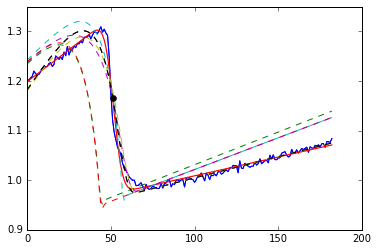

-----------Results of fitting, Edge Position, TOF and lambda:------------
(0.033456, 2.3466857065135289)
[ 0.0218234  0.0258374  0.0289504  0.033456   0.         0.       ]
[ 607 1025]
[ 97 120]
-----------Fitting calibration Bragg Edge--------------
[[Model]]
    Model(AdvancedBraggEdegFittingAll)
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 31
    # data points      = 418
    # variables        = 7
    chi-square         = 0.02860
    reduced chi-square = 0.00007
    Akaike info crit   = -3994.54422
    Bayesian info crit = -3966.29585
[[Variables]]
    t0:      194.527021 (init= 193.0836)
    sigma:  -12.3419898 (init=-12.65845)
    alpha:  -1.12643725 (init=-4.590138)
    a1:      0.42768835 (init= 0.6315053)
    a2:      0.00090552 (init= 0.0009304044)
    a5:      0.00066469 (init= 0.0005835652)
    a6:     -630.468505 (init=-397.5096)



AdvancedBraggEdgeFitting.py:49: RuntimeWarning: invalid value encountered in multiply
  return a1 + term0(t,a2,a6) + term1(t,a2,a5,a6) * (1-(term3(t,t0,sigma) - term4(t,t0,alpha,sigma)* term5(t,t0,alpha,sigma)))


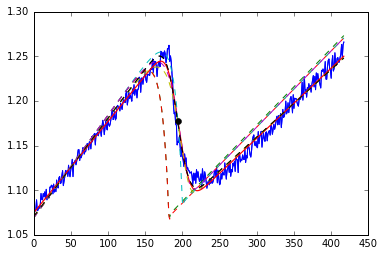

-----------Results of fitting, Edge Position, TOF and lambda:------------
(0.0410429, 2.878849437585608)
[ 0.0218234  0.0258374  0.0289504  0.033456   0.0410429  0.       ]
[1025 2116]
[120 187]
-----------Fitting calibration Bragg Edge--------------
[[Model]]
    Model(AdvancedBraggEdegFittingAll)
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 701
    # data points      = 1091
    # variables        = 7
    chi-square         = 0.58276
    reduced chi-square = 0.00054
    Akaike info crit   = -8206.50664
    Bayesian info crit = -8171.54269
[[Variables]]
    t0:      595.738836 (init= 602.355)
    sigma:  -6.09759177 (init=-4.753259)
    alpha:  -15.4409152 (init=-30.05863)
    a1:      0.39474765 (init= 0.5657602)
    a2:      0.00044151 (init= 0.0005414476)
    a5:     -0.00019833 (init=-0.0004357932)
    a6:     -1171.56441 (init=-655.6838)



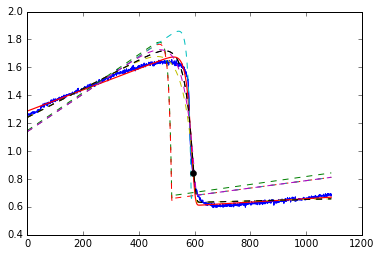

-----------Results of fitting, Edge Position, TOF and lambda:------------
(0.058145000000000002, 4.078432580261512)
[ 0.0218234  0.0258374  0.0289504  0.033456   0.0410429  0.058145 ]


In [17]:
#Here I try to use the BE Advanced fitting to fit single edges
print(peaks) # here I see which are the positions of the peaks in the cal spectrum
print(peaks_th) # position of the peaks in the theoretical spectrum

# Here I have to loop over the found peaks and fit with the AdvancedBraggEdgeFiltering, I take the 6 peaks found in the cal spectrum and define some range

# first I remove the more peaks that I have in the theoretical spectrum
peaks_ref= peaks_th[-6:]
print(peaks_ref)

# I define here externally the ranges, based on the lambda that I observe in the spectrum.



est_sigma=-1
est_alpha=-10
CalPoints = np.zeros(6)
RefPoints = np.zeros(6)

RefPoints[0]=dhkl_alphaFe[6]*2

for i in range(1, 6):
    RefPoints[i]=dhkl_alphaFe[5-i]*2
#     RefPoints[i,0]=l2tof(RefPoints[i,1])

print('--- RefPoints obtained from lattice parameters ---')
print(RefPoints)


for i in range(0, len(peaks)):
    

    myrange = np.array([find_nearest(mycalLambda, lambda_ranges[i,0]), find_nearest(mycalLambda,lambda_ranges[i,1])])
    range_ref = np.array([find_nearest(mylambda, lambda_ranges[i,0]), find_nearest(mylambda, lambda_ranges[i,1])])
    print(myrange)
    print(range_ref)
            

    print('-----------Fitting calibration Bragg Edge--------------')

    results_cal = AdvancedBraggEdgeFitting.AdvancedBraggEdgeFitting(cal_spectrum_norm, myrange, peaks[i], est_sigma, est_alpha, False)
    print('-----------Results of fitting, Edge Position, TOF and lambda:------------')
    print(mycaltof[myrange[0]+results_cal['t0']], mycalLambda[myrange[0]+results_cal['t0']])
    CalPoints[i] = mycaltof[myrange[0]+results_cal['t0']]
#     CalPoints[i,1] = mycalLambda[myrange[0]+results_cal['t0']]

#     print('----------Fitting theoretical Bragg Edge---------------')
    #the same for the reference

#     I substitute this part with the theoretical numbers from the lattice parameters

#     results_th = AdvancedBraggEdgeFitting.AdvancedBraggEdgeFitting(myspectrum_norm, range_ref, peaks_ref[i], est_sigma, est_alpha, False)

#     print('-----------Results of fitting, t0, TOF and lambda:------------')
#     print( mytof[range_ref[0]+results_th['t0']],mylambda[range_ref[0]+results_th['t0']])
#     RefPoints[i,0] = mytof[range_ref[0]+results_th['t0']]
#     RefPoints[i,1] = mylambda[range_ref[0]+results_th['t0']]

    print(CalPoints)
#     print(RefPoints)

## I will then fit the calculated TOF to the theoretical lambda, x= mylambda y=mycaltof 

[ 0.01384362  0.00101174]
[ 1.52787084  1.80655379  2.02203139  2.32657587  2.86160842  3.96781794]
[ 1.52   1.787  2.     2.32   2.853  4.027]


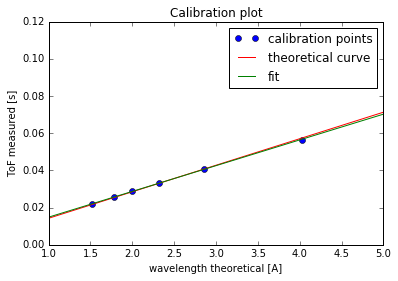

In [23]:
z = np.polyfit(mylambda[peaks_th[3:]],mycaltof[peaks[:]],1) # here I have to select which peaks to be used
print(z)
print(mycalLambda[peaks[:]])
print(mylambda[peaks_th[3:]])


plt.plot( mylambda[peaks_th[3:]],mycaltof[peaks[0:6]],'ob')
plt.plot( mylambda, mytof,'-r')
plt.plot(mylambda, mylambda*z[0]+z[1],'-g')
plt.xlim(1,5)
plt.xlabel('wavelength theoretical [A]')
plt.ylabel('ToF measured [s]')
# plt.ylim(0.0,0.03)
plt.legend(['calibration points','theoretical curve', 'fit'])
plt.title('Calibration plot')


In [ ]:
# this is now to compute T0 and L
T0 = z[1]
L = (z[0]*h/m)/1e-10
print(T0,L)

[ 1.532  1.812  2.026  2.34   2.866  4.054]
[ 0.0218234  0.0258374  0.0289504  0.033456   0.0410429  0.058145 ]
[  6.94236809e+01   1.71234505e-02]


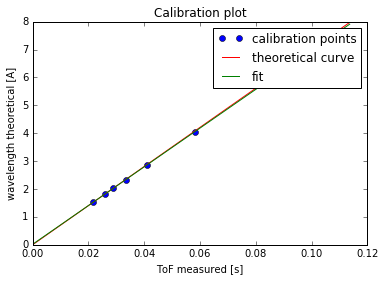

In [24]:
# Here I repeat the calibration again, but with the values obtained from the fitting
# and exclude the first 3 peaks, not idoneous for the ref spectrum (prob too little signal points in the ref)
print(RefPoints)
print(CalPoints)

z= np.polyfit(CalPoints, RefPoints, 1)
print(z)


plt.plot(CalPoints,RefPoints,'ob')
plt.plot( mytof, mylambda,'-r')
plt.plot( mytof, mytof*z[0]+z[1],'-g')
# plt.xlim(1,5)
plt.ylabel('wavelength theoretical [A]')
plt.xlabel('ToF measured [s]')
# plt.ylim(0.0,0.03)
plt.legend(['calibration points','theoretical curve', 'fit'])
plt.title('Calibration plot')

In [27]:
# This is instead to compute l0 and L
lambda0 = z[1]
L = (h/(m*z[0]))/1e-10
print(lambda0,L,l2tof(lambda0))

(0.017123450517426357, 56.983927628931426, 0.0002466514348742195)


# My final result for IMAT flight-path calibration:
## L = 56.98 m
## lambda0 = 0.017
## T0 = 0.0002466


## Some tests here to get the peak height 

[163 215]
[54 60]
-----------Fitting calibration Bragg Edge--------------
[[Model]]
    Model(AdvancedBraggEdegFittingAll)
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 99
    # data points      = 52
    # variables        = 7
    chi-square         = 0.00238
    reduced chi-square = 0.00005
    Akaike info crit   = -505.65049
    Bayesian info crit = -491.99179
[[Variables]]
    t0:      28.6728265 (init= 32.38533)
    sigma:  -0.88427724 (init=-0.03565006)
    alpha:  -0.26394294 (init=-11.55164)
    a1:      0.93378767 (init= 0.941147)
    a2:      0.00189113 (init= 0.004333312)
    a5:     -0.00047878 (init=-0.002614806)
    a6:     -32.7793530 (init=-10.06215)



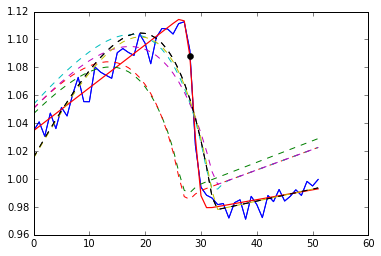

-----------Results of fitting, Edge Position, TOF and lambda:------------
(0.0218234, 1.5307466776520611)


/home/carminati_c/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [28]:
# I'll do again a single BE fitting to understand how to get pick height
for i in range(0, 1):
    

    myrange = np.array([find_nearest(mycalLambda, lambda_ranges[i,0]), find_nearest(mycalLambda,lambda_ranges[i,1])])
    range_ref = np.array([find_nearest(mylambda, lambda_ranges[i,0]), find_nearest(mylambda, lambda_ranges[i,1])])
    print(myrange)
    print(range_ref)
            

    print('-----------Fitting calibration Bragg Edge--------------')

    results_cal = AdvancedBraggEdgeFitting.AdvancedBraggEdgeFitting(cal_spectrum_norm, myrange, peaks[i], est_sigma, est_alpha, False)
    print('-----------Results of fitting, Edge Position, TOF and lambda:------------')
    print(mycaltof[myrange[0]+results_cal['t0']], mycalLambda[myrange[0]+results_cal['t0']])

t0=results_cal['t0']
sigma = results_cal['sigma']
alpha = results_cal['alpha']
a1 = results_cal['a1']
a2 = results_cal['a2']
a5 = results_cal['a5']
a6 = results_cal['a6']
results = results_cal['final_result']



28.6728265936
1.08846897001
1.11435782418
0.979469130667
('peak height: ', 0.13488869350785981)


/home/carminati_c/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:5: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/carminati_c/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:6: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/carminati_c/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:7: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/carminati_c/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:9: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/carminati_c/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:10: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/carminati_c/anacon

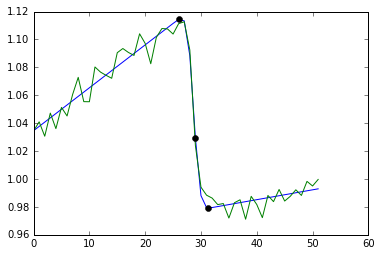

In [29]:
fit = results.best_fit
print(t0)
plt.plot(fit)
plt.plot(results.data)
plt.plot(round(t0),fit[round(t0)],'ok')
plt.plot(t0+3*sigma, fit[t0+3*sigma], 'ok')
plt.plot(t0-3*sigma, fit[t0-3*sigma], 'ok')

print(fit[t0])
print(fit[t0+3*sigma])
print(fit[t0-3*sigma])
print('peak height: ', np.abs(fit[t0-3*sigma]-fit[t0+3*sigma])) # i must say that it works but not for all cases 